# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [445]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

Load feature names.

In [96]:
feature_names = []
with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [567]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000, 126) (1124, 126)


## (1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

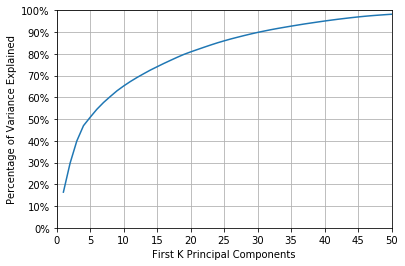

In [98]:
def P1():
    ### STUDENT START ###
    #Initializes the PCA
    pca = PCA()
    #Transforms the data into Principle Components
    pca.fit(train_data)
    #Uses Cum Sum to find the cumulative sum over the first 50 principal components and plots these values
    x = plt.plot(range(1,51),np.cumsum(pca.explained_variance_ratio_)[:50])
    #Adds axis labels and sets the ticks for these axis
    plt.xlabel('First K Principal Components')
    plt.ylabel('Percentage of Variance Explained')
    plt.xticks(range(0,51,5))
    plt.xlim(0,50)
    plt.ylim(0,1)
    _ = plt.yticks(np.arange(0,1.1,.1),['{:.0f}%'.format(round(i*100,0)) for i in np.arange(0,1.1,.1)])
    plt.grid('on')
    ### STUDENT END ###

P1()

## (2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

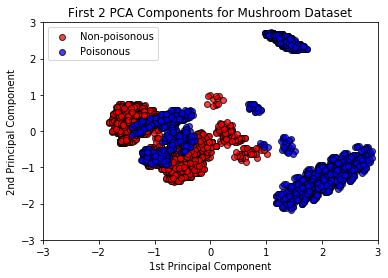

In [456]:
def P2():
    ### STUDENT START ###
    #Constructs the Principle Component Model limited to 2 components
    pca2 = PCA(n_components=2)
    #Conducts PCA analysis on the Training Data 
    mod_train_data = pca2.fit_transform(train_data)
    #Builds Dictionary Map for using in color plots and Labels
    Map = {0:{'Color':'Red','Label':'Non-poisonous'},
          1:{'Color':'Blue','Label':'Poisonous'}
          }
    #Loops through the Map and Plots the data with the corresponding color and label
    for i in Map.keys():
        _ = plt.scatter(mod_train_data[train_labels==i,0],mod_train_data[train_labels==i,1],
                        alpha=0.75,c=Map[i]['Color'],label=Map[i]['Label'],edgecolors='black')
    #Adds labels to Plot and sets dimensions
    plt.ylim(-3,3)
    _ = plt.xlabel('1st Principal Component')
    _ = plt.ylabel('2nd Principal Component')
    _ = plt.legend(loc='best')
    _ = plt.title('First 2 PCA Components for Mushroom Dataset')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    ### STUDENT END ###

P2()

## (3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

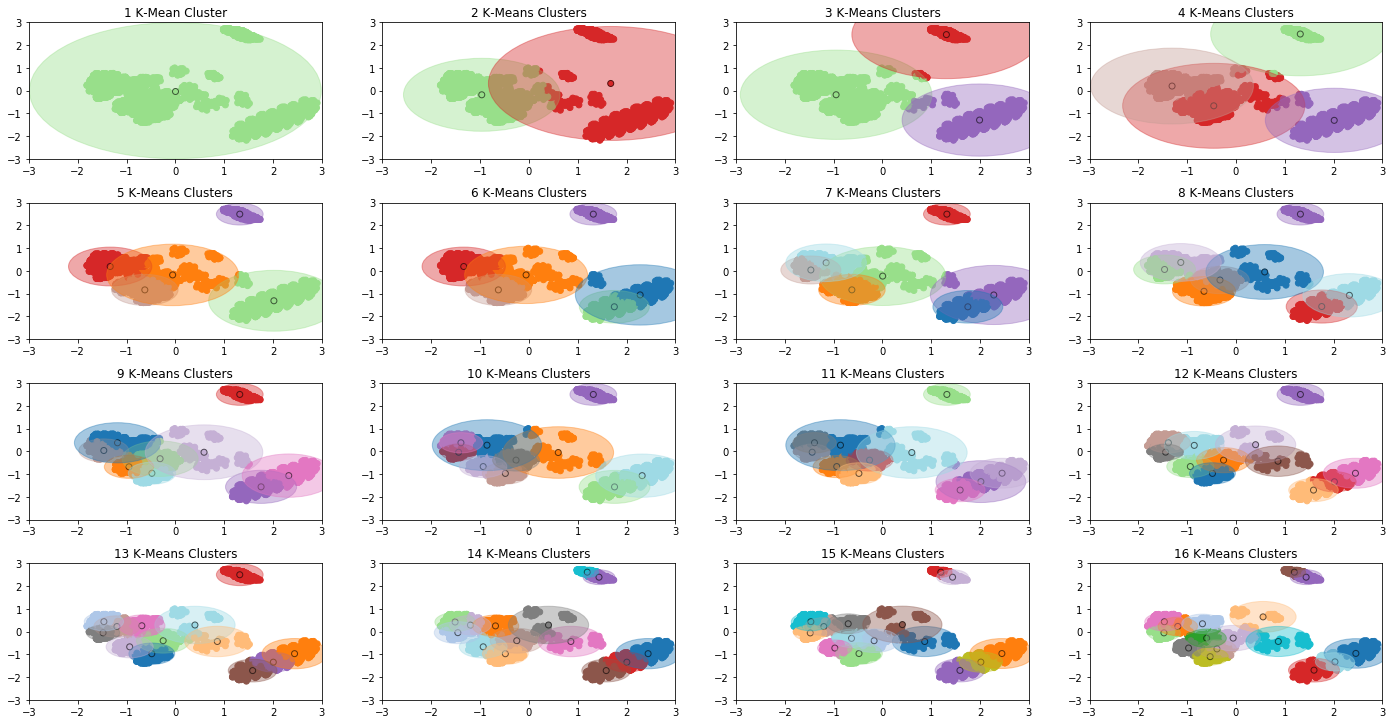

In [455]:
### STUDENT START ###
def get_cluster_centers(clusters):
    #Creates a dataframe
    df = pd.DataFrame(clusters.labels_,columns=['cluster'])
    #Finds the applicable cluster for each point and defines the centroid
    Centroid_x = df.apply(lambda x: clusters.cluster_centers_[x['cluster'],0],axis=1)
    Centroid_y = df.apply(lambda x: clusters.cluster_centers_[x['cluster'],1],axis=1)
    df['centroid_x'] = Centroid_x
    df['centroid_y'] = Centroid_y
    #Measure the distance between the appicable centoroid and that point
    df['distance'] = metrics.pairwise.paired_euclidean_distances(df[['centroid_x','centroid_y']],mod_train_data)
    #Returns the max for each centroid
    max_distance = df.groupby('cluster')['distance'].max()
    return max_distance
### STUDENT END ###

def P3():
    ### STUDENT START ###
    #Constructs the Principle Component Model limited to 2 component
    pca3 = PCA(n_components=2)
    #Conducts PCA analysis on the Training Data 
    mod_train_data = pca3.fit_transform(train_data)
    #Creates a series of subplots and then graphs the applicable data
    ax, fig = plt.subplots(4,4,figsize=(20,10))
    plt.title('K-Means for 1-16 Clusters over PCA 2d Projected Data')
    plt.tight_layout()
    #Gets the color map for use in plots
    colors = plt.get_cmap('tab20').colors
    colors = list(colors)
    #Shuffles the colors so the similar shades arent next to each other
    np.random.shuffle(colors)
    for k in range(1,17):
        #Constructs the k-means algorithim
        kmeans = KMeans(n_clusters=k)
        #Fits the Kmeans on PCA adjusted data
        clusters = kmeans.fit(mod_train_data)
        #Finds the radius from the centroid to the max point
        radii = get_cluster_centers(clusters)
        #Plots the data
        ax = plt.subplot(4,4, k)
        df = pd.DataFrame(clusters.labels_,columns=['labels'])
        df['color'] = df['labels'].apply(lambda x: colors[x])
        
        plt.scatter(mod_train_data[:, 0], mod_train_data[:, 1],color=df['color'],cmap='tab20')
        plt.scatter(clusters.cluster_centers_[:,0],clusters.cluster_centers_[:,1],color=colors[:k],
                    cmap='tab20',edgecolors='black')
        plt.xlim(-3,3)
        plt.ylim(-3,3)
        if k == 1:
            plt.title('{} K-Mean Cluster'.format(k))
        else:
            plt.title('{} K-Means Clusters'.format(k))
        for i in range(k):
            circle = plt.Circle((clusters.cluster_centers_[i,0], clusters.cluster_centers_[i,1]),radii[i],color=colors[i],alpha=.4)
            ax.add_artist(circle)
    ### STUDENT END ###

P3()

## (4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

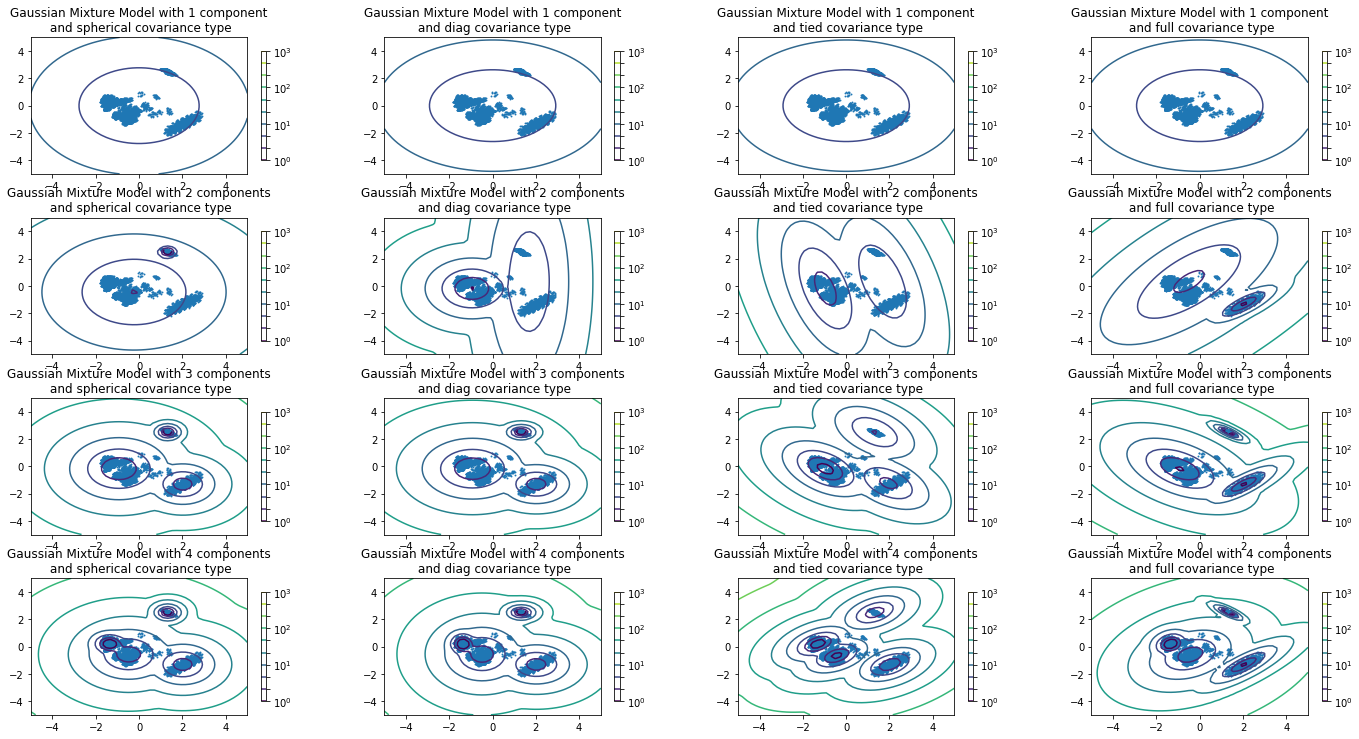

In [499]:
def P4():
    ### STUDENT START ###
    #Constructs the Principle Component Model limited to 2 component
    pca4 = PCA(n_components=2)
    #Conducts PCA analysis on the Training Data 
    mod_train_data = pca4.fit_transform(train_data)
    #Defines the critera we are attempting to evaluate
    covar_type = ('spherical', 'diag', 'tied', 'full')
    mixture_components = range(1,5)
    #Sets up the plot
    ax, fig = plt.subplots(4,4,figsize=(20,10))
    plt.title('Various Gaussian Mixture Models over PCA 2d Projected Data')
    plt.tight_layout()
    #Loops through the mixture components and a covariance matrix type
    for i in range(0,4):
        for j in range(0,4):
            # Fit a Gaussian Mixture Model with a mixture component from 1-4 and a covariance matrix type
            gmm = GaussianMixture(n_components=mixture_components[i],covariance_type=covar_type[j])
            gmm.fit(mod_train_data)

            # Display predicted scores by the model as a contour plot
            x = np.linspace(-5., 5.)
            y = np.linspace(-5., 5.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gmm.score_samples(XX)
            Z = Z.reshape(X.shape)
            ax = plt.subplot(4,4, (i*4+j)+1)
            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                             levels=np.logspace(0, 3, 10))
            CB = plt.colorbar(CS, shrink=0.8, extend='both')
            plt.scatter(mod_train_data[:, 0], mod_train_data[:, 1], .8)
            if i == 0:
                plt.title('Gaussian Mixture Model with 1 component\n and {} covariance type'.format(covar_type[j]))
            else:
                plt.title('Gaussian Mixture Model with {} components\n and {} covariance type'.format(mixture_components[i],covar_type[j]))
    ### STUDENT END ###

P4()

## (5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [607]:
### STUDENT START ###
def get_Gaussian_Mixture_Score(mod_train_data,train_labels,test_data,test_labels,gmm_components=4,covar_type='full'):
    labels = {}
    for i in (0,1):
        #Find training data matching example (positive, negative)
        temp_train_data = mod_train_data[train_labels==i]
        #Construct the Gaussian Mixture Model using n_components and a full covariance
        gmm = GaussianMixture(n_components=gmm_components,covariance_type=covar_type)
        #Fit the modified training data to the Gaussian Mixture Model 
        gmm.fit(temp_train_data)
        #Score this model on the test data
        scores = gmm.score_samples(test_data)
        labels[i] = scores
    prediction = np.where(labels[0] > labels[1],0,1)
    return np.mean(prediction==test_labels)
### STUDENT END ###

def P5():
    ### STUDENT START ###
    #Fit the PCA Model
    pca5 = PCA(n_components=2)
    #Transform the training and test data
    mod_train_data = pca5.fit_transform(train_data)
    mod_test_data = pca5.transform(test_data)
    #Trains the Gaussian Mixture Model
    score = get_Gaussian_Mixture_Score(mod_train_data,train_labels,mod_test_data,test_labels)
    print('The accuracy of our prediction model on the test data is {:.2f}%'.format(score*100))
    ### STUDENT END ###

P5()

The accuracy of our prediction model on the test data is 95.02%


## (6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [649]:
covar_type = ('spherical', 'diag', 'tied', 'full')
gmm_components = range(1,10)
pca_components = range(1,20)

def get_paramaters(covar='full',pca=1,gmm=1):
    """
    Formulas found using the following link
    For full, spherical, and diagonal the calculations can be found here
    https://stats.stackexchange.com/questions/280893/number-of-parameters-in-multivariate-gaussian-for-different-covariance-matrices
    """
    covar_params  = 0
    number_of_classes = 2
    if covar == 'tied':
        """
        This may be an incorrect assumption, but since all components share one covariances matrix, 
        we don't need to multiply by the number of gmm components. Thus the size of the one tied covariance matrix
        is just the same as one full multiplied by the number of classes
        """
        return (pca+(pca*(pca+1))/2)*number_of_classes 
    if covar == 'full':
        covar_params = pca+(pca*(pca+1))/2#See Link Above
    elif covar == 'spherical':
        covar_params = pca+1#See Link Above
    elif covar == 'diag':
        covar_params = 2*pca#See Link Above
    #Multiply by the covariance parameters by the number of gmm components and the number of classes    
    return (covar_params*gmm)*number_of_classes

def P6():
    ### STUDENT START ###
    df = pd.DataFrame()
    #Loops through each GMM type
    for gmm_c in gmm_components:
        #Loops through each PCA type
        for pca_c in pca_components:
            #Go through each covar type
            for ct in covar_type:
                parameters = get_paramaters(covar=ct,pca=pca_c,gmm=gmm_c)
                #Checks the number of paramaters
                if parameters <= 50:
                    #Fit the PCA Model
                    pca6 = PCA(n_components=pca_c)
                    #Transform the training and test data
                    mod_train_data = pca6.fit_transform(train_data)
                    mod_test_data = pca6.transform(test_data)
                    #Gets the Gaussian Mixture Score (using function from problem 6) for a given number of components 
                    #and covar type
                    accy = get_Gaussian_Mixture_Score(mod_train_data,train_labels,mod_test_data,test_labels,
                                                    gmm_components=gmm_c,covar_type=ct)
                    #Creates of Dictory of values for adding to the datafram
                    frame = {'Parameters':parameters,'PCA Components':pca_c,'GMM Components':gmm_c,'Covar Type':ct,
                             'Accuracy':accy}
                    #Appends these values to a dataframe
                    if df.empty:
                         df = pd.DataFrame(frame,index=[0])
                    else:
                        df = df.append(pd.DataFrame(frame,index=[0]),ignore_index=True)
    #Sort the data frame by greatest accuracy with least parameters
    df = df.sort_values(['Accuracy','Parameters'],ascending=[False,True]).reset_index(drop=True)
    #print the top 5 values
    print('\033[1m\033[4mThe Top 5 models Are:\033[0m')
    print(df.head(5))
    ### STUDENT END ###

P6()

The Top 5 models Are:
   Accuracy Covar Type  GMM Components  PCA Components  Parameters
0  0.991103       tied               9               5          40
1  0.982206       tied               5               5          40
2  0.981317       tied               4               5          40
3  0.979537       tied               7               5          40
4  0.977758       tied               8               5          40
